In [2]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

#### These data used in this analysis are taken from 6 sources:
- Accommodation Type & Heating Type Data: Taken from the 2021 ONS Census
    - https://www.ons.gov.uk/datasets/RM003/editions/2021/versions/1/filter-outputs/183399a4-c2b3-4012-b706-b7c1f81ce1a9#get-data
- Electricity and Gas Consumption Data: Department for Energy Security and Net Zero
    - https://www.data.gov.uk/dataset/e7d4c1cf-45a0-4070-878f-24ad9641f655/domestic-electricity-and-gas-estimates-by-postcode-in-great-britain
    - https://www.gov.uk/government/statistics/postcode-level-electricity-statistics-2022
- Population by postcode & LAD
    - https://www.nomisweb.co.uk/sources/census_2021_pc
    - https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland
- Income Data
    - https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales

### This code cleans and transforms raw ONS & DESNZ data into workable geographic data

This code cleans raw ONS energy consumption data through the following steps
- Load raw data in and inspect
- Orignal data contains every UK postal code (1.5m rows). We instead deal with outcodes (2550) rather all 1.5 mn rows of postcode data
- Leverage the *geopy* package to retrieve the latitude and longitude data based on outcodes
- Covert new Latitude_Longitude column into point data and save cleaned and transformed data into new file
- Plot and inspect out new dataset

## 1. Gas Consumption Data

In [ ]:
# read in data
df = pd.read_csv('data/old/2022_gascon.csv')

# dataset is too large
# cut from specific postcodes to outcode (i.e. N4 2XG > N4) & check
df = df[df['Postcode'] == 'All postcodes']

# clean names
# clean column names function
def clean_column_names(column_name):
    return column_name.strip().replace(' ', '_').lower()
df.columns = [clean_column_names(col) for col in df.columns]

# check
df.head()

In [ ]:
# info
df.info()

### The following code uses the *geopy* package to get coordinates using *outcode* column

In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")

# function to get lat / long
def get_lat_lon(outcode):
    try:
        location = geolocator.geocode(f"{outcode}, United Kingdom")
        return (location.latitude, location.longitude)
    except:
        return (None, None)

# avoid hitting rate limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# apply to outcode column
df['Latitude_Longitude'] = df['outcode'].apply(lambda x: get_lat_lon(x))

In [ ]:
# save df as new csv
df.to_csv('updated_file.csv', index=False)

### 2. Read in *updated_file.csv* (with geometry column) & transform into geographic data

In [82]:
df = pd.read_csv('data/old/updated_file.csv')

In [83]:
# convert string coordinates to a point object
def parse_coordinates(coord_str):
    # strip parentheses
    clean_str = coord_str.strip('()')
    try:
        lat, lon = clean_str.split(',')
        # convert lat / long to float
        return Point(float(lon), float(lat))
    except ValueError:
        # none option
        return None

# apply to 'Latitude_Longitude'
df['geometry'] = df['Latitude_Longitude'].apply(parse_coordinates)

# remove 'None' rows
df = df[df['geometry'].notna()]

# df to gdf
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# WSG 84
gdf.set_crs(epsg=4326, inplace=True)

# save as .gpkg
gdf.to_file('updated_file.gpkg', driver='GPKG')

In [84]:
# load gpkg
gdf = gpd.read_file('data/old/updated_file.gpkg')

# check it worked
gdf.head()

,outcode,postcode,num_meters,total_cons_kwh,mean_cons_kwh,median_cons_kwh,Latitude_Longitude,geometry
0,AB1,All postcodes,157,2.341706e+06,14915.321679,9644.512519,"(57.1456496, -2.107086)",POINT (-2.10709 57.14565)
1,AB10,All postcodes,10756,1.267846e+08,11787.339920,9315.654063,"(57.1363479, -2.1147281)",POINT (-2.11473 57.13635)
2,AB11,All postcodes,9930,9.760425e+07,9829.229976,7679.996322,"(51.4765615, -0.473901)",POINT (-0.47390 51.47656)
3,AB12,All postcodes,11072,1.321706e+08,11937.376253,10712.676818,"(51.4765368, -0.481525)",POINT (-0.48152 51.47654)
4,AB13,All postcodes,1204,2.392245e+07,19869.147242,18043.667598,"(51.4764944, -0.4904462)",POINT (-0.49045 51.47649)


In [85]:
# drop unneccessary columns
columns_to_drop = ['postcode', 'Latitude_Longitude', 'num_meters']
gdf = gdf.drop(columns=columns_to_drop)
# check
gdf.head()

,outcode,total_cons_kwh,mean_cons_kwh,median_cons_kwh,geometry
0,AB1,2.341706e+06,14915.321679,9644.512519,POINT (-2.10709 57.14565)
1,AB10,1.267846e+08,11787.339920,9315.654063,POINT (-2.11473 57.13635)
2,AB11,9.760425e+07,9829.229976,7679.996322,POINT (-0.47390 51.47656)
3,AB12,1.321706e+08,11937.376253,10712.676818,POINT (-0.48152 51.47654)
4,AB13,2.392245e+07,19869.147242,18043.667598,POINT (-0.49045 51.47649)


In [86]:
# rename columns to specificy gas bc we will add electricity data later

gdf = gdf.rename(columns={
    'total_cons_kwh': 'gas_total_cons_kwh',
    'mean_cons_kwh': 'gas_mean_cons_kwh',
    'median_cons_kwh': 'gas_median_cons_kwh'
})

# check
gdf.head()

,outcode,gas_total_cons_kwh,gas_mean_cons_kwh,gas_median_cons_kwh,geometry
0,AB1,2.341706e+06,14915.321679,9644.512519,POINT (-2.10709 57.14565)
1,AB10,1.267846e+08,11787.339920,9315.654063,POINT (-2.11473 57.13635)
2,AB11,9.760425e+07,9829.229976,7679.996322,POINT (-0.47390 51.47656)
3,AB12,1.321706e+08,11937.376253,10712.676818,POINT (-0.48152 51.47654)
4,AB13,2.392245e+07,19869.147242,18043.667598,POINT (-0.49045 51.47649)


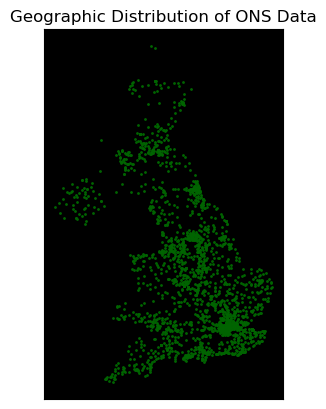

In [87]:
# plot data
# aesthetics
ax = gdf.plot(color='darkgreen', markersize=1)

# background, remove axis labels & title
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Geographic Distribution of ONS Data')

# plot
plt.show()

## 2. Electricity Consumption Data

In [89]:
edf = pd.read_csv("data/old/electricity_consumption.csv")

In [90]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283339 entries, 0 to 1283338
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Outcode          1283339 non-null  object 
 1   Postcode         1283339 non-null  object 
 2   Num_meters       1283339 non-null  int64  
 3   Total_cons_kwh   1283339 non-null  float64
 4   Mean_cons_kwh    1283339 non-null  float64
 5   Median_cons_kwh  1283339 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 58.7+ MB


In [91]:
# similar cleaning as above
# cut from specific postcodes to outcode (i.e. N4 2XG > N4) & check
edf = edf[edf['Postcode'] == 'All postcodes']

# clean names
# clean column names function
def clean_column_names(column_name):
    return column_name.strip().replace(' ', '_').lower()
edf.columns = [clean_column_names(col) for col in edf.columns]

# check
edf.head()

,outcode,postcode,num_meters,total_cons_kwh,mean_cons_kwh,median_cons_kwh
0,AB10,All postcodes,12895,3.478418e+07,2697.493903,1932.2
486,AB11,All postcodes,13106,3.311319e+07,2526.566968,1865.5
949,AB12,All postcodes,12723,4.026686e+07,3164.887481,2478.5
1494,AB13,All postcodes,1279,5.651458e+06,4418.653833,3483.7
1562,AB14,All postcodes,2319,7.910751e+06,3411.276967,2491.8


In [92]:
# drop unneccessary columns
columns_to_drop = ['postcode', 'num_meters']
edf = edf.drop(columns=columns_to_drop)

# check
edf.head()

,outcode,total_cons_kwh,mean_cons_kwh,median_cons_kwh
0,AB10,3.478418e+07,2697.493903,1932.2
486,AB11,3.311319e+07,2526.566968,1865.5
949,AB12,4.026686e+07,3164.887481,2478.5
1494,AB13,5.651458e+06,4418.653833,3483.7
1562,AB14,7.910751e+06,3411.276967,2491.8


In [93]:
edf = edf.rename(columns={
    'total_cons_kwh': 'elec_total_cons_kwh',
    'mean_cons_kwh': 'elec_mean_cons_kwh',
    'median_cons_kwh': 'elec_median_cons_kwh'
})

# check
edf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2744 entries, 0 to 1283327
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   outcode               2744 non-null   object 
 1   elec_total_cons_kwh   2744 non-null   float64
 2   elec_mean_cons_kwh    2744 non-null   float64
 3   elec_median_cons_kwh  2744 non-null   float64
dtypes: float64(3), object(1)
memory usage: 107.2+ KB


In [94]:
# we already have geography column loaded above
# join to this data to gas gdf
# df to gdf

joined_df = pd.merge(gdf, edf, on='outcode', how='left')

# Display the result to verify the join
joined_df

,outcode,gas_total_cons_kwh,gas_mean_cons_kwh,gas_median_cons_kwh,geometry,elec_total_cons_kwh,elec_mean_cons_kwh,elec_median_cons_kwh
0,AB1,2.341706e+06,14915.321679,9644.512519,POINT (-2.10709 57.14565),NaN,NaN,NaN
1,AB10,1.267846e+08,11787.339920,9315.654063,POINT (-2.11473 57.13635),3.478418e+07,2697.493903,1932.2
2,AB11,9.760425e+07,9829.229976,7679.996322,POINT (-0.47390 51.47656),3.311319e+07,2526.566968,1865.5
3,AB12,1.321706e+08,11937.376253,10712.676818,POINT (-0.48152 51.47654),4.026686e+07,3164.887481,2478.5
4,AB13,2.392245e+07,19869.147242,18043.667598,POINT (-0.49045 51.47649),5.651458e+06,4418.653833,3483.7
...,...,...,...,...,...,...,...,...
2347,YO51,3.446372e+07,11690.542191,9991.557839,POINT (-1.36410 54.06386),1.145161e+07,3411.264338,2485.4
2348,YO61,3.246397e+07,11548.903847,9706.484860,POINT (-1.20051 54.14060),3.012697e+07,4497.234029,3041.3
2349,YO62,3.898847e+07,11541.878606,9903.035177,POINT (-0.91166 54.26478),2.423938e+07,3982.810295,2609.5
2350,YO7,7.091023e+07,10604.191627,9105.330965,POINT (-1.34580 54.23065),3.538998e+07,3607.909462,2586.0


In [95]:
joined_df = joined_df.dropna(subset=['elec_total_cons_kwh', 'elec_mean_cons_kwh', 'elec_median_cons_kwh'])

# check if 'AB1' is remove
joined_df

,outcode,gas_total_cons_kwh,gas_mean_cons_kwh,gas_median_cons_kwh,geometry,elec_total_cons_kwh,elec_mean_cons_kwh,elec_median_cons_kwh
1,AB10,1.267846e+08,11787.339920,9315.654063,POINT (-2.11473 57.13635),3.478418e+07,2697.493903,1932.2
2,AB11,9.760425e+07,9829.229976,7679.996322,POINT (-0.47390 51.47656),3.311319e+07,2526.566968,1865.5
3,AB12,1.321706e+08,11937.376253,10712.676818,POINT (-0.48152 51.47654),4.026686e+07,3164.887481,2478.5
4,AB13,2.392245e+07,19869.147242,18043.667598,POINT (-0.49045 51.47649),5.651458e+06,4418.653833,3483.7
5,AB14,2.486380e+07,13338.948332,11342.363176,POINT (-2.27130 57.09648),7.910751e+06,3411.276967,2491.8
...,...,...,...,...,...,...,...,...
2347,YO51,3.446372e+07,11690.542191,9991.557839,POINT (-1.36410 54.06386),1.145161e+07,3411.264338,2485.4
2348,YO61,3.246397e+07,11548.903847,9706.484860,POINT (-1.20051 54.14060),3.012697e+07,4497.234029,3041.3
2349,YO62,3.898847e+07,11541.878606,9903.035177,POINT (-0.91166 54.26478),2.423938e+07,3982.810295,2609.5
2350,YO7,7.091023e+07,10604.191627,9105.330965,POINT (-1.34580 54.23065),3.538998e+07,3607.909462,2586.0


In [412]:
new_column_order = [col for col in joined_df.columns if col != 'geometry']

# 'geometry' as last column
new_column_order.append('geometry')

# reorder the df
joined_df = joined_df[new_column_order]
joined_df

,outcode,gas_median_cons_kwh,elec_median_cons_kwh,index_right,LAD22CD,LAD22NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
1,AB10,9315.654063,1932.2,338.0,S12000033,Aberdeen City,387763.0,808479.0,-2.20398,57.1670,2d2da68f-ad23-4538-9770-7af143a96979,POINT (393154.772 805054.787)
2,AB11,7679.996322,1865.5,292.0,E09000017,Hillingdon,508166.0,183120.0,-0.44182,51.5366,bfff99b5-c460-4d4d-9e3e-178770575e1f,POINT (506081.975 176393.051)
3,AB12,10712.676818,2478.5,292.0,E09000017,Hillingdon,508166.0,183120.0,-0.44182,51.5366,bfff99b5-c460-4d4d-9e3e-178770575e1f,POINT (505552.584 176379.298)
4,AB13,18043.667598,3483.7,292.0,E09000017,Hillingdon,508166.0,183120.0,-0.44182,51.5366,bfff99b5-c460-4d4d-9e3e-178770575e1f,POINT (504933.148 176361.775)
5,AB14,11342.363176,2491.8,338.0,S12000033,Aberdeen City,387763.0,808479.0,-2.20398,57.1670,2d2da68f-ad23-4538-9770-7af143a96979,POINT (383659.965 800643.381)
...,...,...,...,...,...,...,...,...,...,...,...,...
2347,YO51,9991.557839,2485.4,173.0,E07000165,Harrogate,427473.0,464652.0,-1.58161,54.0771,72655d00-7f6d-420b-8de7-e4a3f4280a7e,POINT (441717.948 463289.077)
2348,YO61,9706.484860,3041.3,172.0,E07000164,Hambleton,443009.0,490546.0,-1.34049,54.3087,5a2eb8b4-db0f-4896-a312-bad0a665e27a,POINT (452328.148 471935.133)
2349,YO62,9903.035177,2609.5,175.0,E07000167,Ryedale,474645.0,478532.0,-0.85735,54.1971,69817964-d3b4-4a58-9d61-3350c46fa387,POINT (470985.390 486003.490)
2350,YO7,9105.330965,2586.0,172.0,E07000164,Hambleton,443009.0,490546.0,-1.34049,54.3087,5a2eb8b4-db0f-4896-a312-bad0a665e27a,POINT (442744.096 481856.990)


In [416]:
gas_elec_final_df = joined_df.drop(columns=['LAD22NM', 'BNG_E',	'BNG_N', 'LONG', 'LAT', 'GlobalID'])

# print
gas_elec_final_df.head()

,outcode,gas_median_cons_kwh,elec_median_cons_kwh,index_right,LAD22CD,geometry
1,AB10,9315.654063,1932.2,338.0,S12000033,POINT (393154.772 805054.787)
2,AB11,7679.996322,1865.5,292.0,E09000017,POINT (506081.975 176393.051)
3,AB12,10712.676818,2478.5,292.0,E09000017,POINT (505552.584 176379.298)
4,AB13,18043.667598,3483.7,292.0,E09000017,POINT (504933.148 176361.775)
5,AB14,11342.363176,2491.8,338.0,S12000033,POINT (383659.965 800643.381)


In [418]:
# save the gdf as a GeoPackage
gas_elec_final_df.to_file('ge_consumptionxpc.gpkg', driver='GPKG')

## 3. Process Population Data

### Add Population data in order to normalise

In [98]:
# read in population data
pop = pd.read_csv("data/pc_pop.csv")
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Postcode Districts  2302 non-null   object
 1   Count               2302 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.1+ KB


In [99]:
# join
popjoined_df = pd.merge(joined_df, pop, left_on='outcode', right_on='Postcode Districts', how='left')

# drop 'Postcode Districts' column
popjoined_df.drop(columns='Postcode Districts', inplace=True)

# verify
popjoined_df

,outcode,gas_total_cons_kwh,gas_mean_cons_kwh,gas_median_cons_kwh,elec_total_cons_kwh,elec_mean_cons_kwh,elec_median_cons_kwh,geometry,Count
0,AB10,1.267846e+08,11787.339920,9315.654063,3.478418e+07,2697.493903,1932.2,POINT (-2.11473 57.13635),NaN
1,AB11,9.760425e+07,9829.229976,7679.996322,3.311319e+07,2526.566968,1865.5,POINT (-0.47390 51.47656),NaN
2,AB12,1.321706e+08,11937.376253,10712.676818,4.026686e+07,3164.887481,2478.5,POINT (-0.48152 51.47654),NaN
3,AB13,2.392245e+07,19869.147242,18043.667598,5.651458e+06,4418.653833,3483.7,POINT (-0.49045 51.47649),NaN
4,AB14,2.486380e+07,13338.948332,11342.363176,7.910751e+06,3411.276967,2491.8,POINT (-2.27130 57.09648),NaN
...,...,...,...,...,...,...,...,...,...
2324,YO51,3.446372e+07,11690.542191,9991.557839,1.145161e+07,3411.264338,2485.4,POINT (-1.36410 54.06386),6475.0
2325,YO61,3.246397e+07,11548.903847,9706.484860,3.012697e+07,4497.234029,3041.3,POINT (-1.20051 54.14060),14626.0
2326,YO62,3.898847e+07,11541.878606,9903.035177,2.423938e+07,3982.810295,2609.5,POINT (-0.91166 54.26478),12068.0
2327,YO7,7.091023e+07,10604.191627,9105.330965,3.538998e+07,3607.909462,2586.0,POINT (-1.34580 54.23065),21311.0


In [100]:
# drop NaNs
popjoined_df = popjoined_df.dropna(subset=['Count'])

# check
popjoined_df

,outcode,gas_total_cons_kwh,gas_mean_cons_kwh,gas_median_cons_kwh,elec_total_cons_kwh,elec_mean_cons_kwh,elec_median_cons_kwh,geometry,Count
30,AL1,1.951529e+08,13384.051935,11212.445815,6.100556e+07,3599.147893,2704.2,POINT (-1.23428 54.57754),39038.0
31,AL10,1.403357e+08,11306.450250,9859.944538,4.131189e+07,3165.904955,2522.9,POINT (-0.22457 51.77064),38933.0
32,AL2,1.304727e+08,13634.931469,12388.751514,3.745483e+07,3754.494150,2917.6,POINT (-1.23429 54.57725),24211.0
33,AL3,1.598886e+08,14040.098902,12535.414310,4.468902e+07,3703.714232,2842.1,POINT (-0.33501 51.76730),29620.0
34,AL4,1.446866e+08,13314.307013,12066.393697,4.348994e+07,3760.153595,2935.4,POINT (-0.24983 51.73707),28431.0
...,...,...,...,...,...,...,...,...,...
2324,YO51,3.446372e+07,11690.542191,9991.557839,1.145161e+07,3411.264338,2485.4,POINT (-1.36410 54.06386),6475.0
2325,YO61,3.246397e+07,11548.903847,9706.484860,3.012697e+07,4497.234029,3041.3,POINT (-1.20051 54.14060),14626.0
2326,YO62,3.898847e+07,11541.878606,9903.035177,2.423938e+07,3982.810295,2609.5,POINT (-0.91166 54.26478),12068.0
2327,YO7,7.091023e+07,10604.191627,9105.330965,3.538998e+07,3607.909462,2586.0,POINT (-1.34580 54.23065),21311.0


In [101]:
# normalise energy consumption by population
popjoined_df['ngas_total_cons_kwh'] = popjoined_df['gas_total_cons_kwh'] / popjoined_df['Count']
popjoined_df['ngas_mean_cons_kwh'] = popjoined_df['gas_mean_cons_kwh'] / popjoined_df['Count']
popjoined_df['ngas_median_cons_kwh'] = popjoined_df['gas_median_cons_kwh'] / popjoined_df['Count']
popjoined_df['nelec_total_cons_kwh'] = popjoined_df['elec_total_cons_kwh'] / popjoined_df['Count']
popjoined_df['nelec_mean_cons_kwh'] = popjoined_df['elec_mean_cons_kwh'] / popjoined_df['Count']
popjoined_df['nelec_median_cons_kwh'] = popjoined_df['elec_median_cons_kwh'] / popjoined_df['Count']

popjoined_df

/Users/nikhildesai/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/nikhildesai/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/nikhildesai/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,outcode,gas_total_cons_kwh,gas_mean_cons_kwh,gas_median_cons_kwh,elec_total_cons_kwh,elec_mean_cons_kwh,elec_median_cons_kwh,geometry,Count,ngas_total_cons_kwh,ngas_mean_cons_kwh,ngas_median_cons_kwh,nelec_total_cons_kwh,nelec_mean_cons_kwh,nelec_median_cons_kwh
30,AL1,1.951529e+08,13384.051935,11212.445815,6.100556e+07,3599.147893,2704.2,POINT (-1.23428 54.57754),39038.0,4999.048652,0.342847,0.287219,1562.722393,0.092196,0.069271
31,AL10,1.403357e+08,11306.450250,9859.944538,4.131189e+07,3165.904955,2522.9,POINT (-0.22457 51.77064),38933.0,3604.542689,0.290408,0.253254,1061.102246,0.081317,0.064801
32,AL2,1.304727e+08,13634.931469,12388.751514,3.745483e+07,3754.494150,2917.6,POINT (-1.23429 54.57725),24211.0,5388.982662,0.563171,0.511699,1547.017209,0.155074,0.120507
33,AL3,1.598886e+08,14040.098902,12535.414310,4.468902e+07,3703.714232,2842.1,POINT (-0.33501 51.76730),29620.0,5397.996161,0.474007,0.423208,1508.744630,0.125041,0.095952
34,AL4,1.446866e+08,13314.307013,12066.393697,4.348994e+07,3760.153595,2935.4,POINT (-0.24983 51.73707),28431.0,5089.042746,0.468302,0.424410,1529.666086,0.132255,0.103246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,YO51,3.446372e+07,11690.542191,9991.557839,1.145161e+07,3411.264338,2485.4,POINT (-1.36410 54.06386),6475.0,5322.581989,1.805489,1.543098,1768.589094,0.526836,0.383846
2325,YO61,3.246397e+07,11548.903847,9706.484860,3.012697e+07,4497.234029,3041.3,POINT (-1.20051 54.14060),14626.0,2219.606777,0.789615,0.663646,2059.822970,0.307482,0.207938
2326,YO62,3.898847e+07,11541.878606,9903.035177,2.423938e+07,3982.810295,2609.5,POINT (-0.91166 54.26478),12068.0,3230.731350,0.956404,0.820603,2008.566743,0.330031,0.216233
2327,YO7,7.091023e+07,10604.191627,9105.330965,3.538998e+07,3607.909462,2586.0,POINT (-1.34580 54.23065),21311.0,3327.400376,0.497592,0.427260,1660.643983,0.169298,0.121346


In [422]:
columns_to_drop = ['gas_total_cons_kwh', 'gas_mean_cons_kwh', 'gas_median_cons_kwh',
                   'elec_total_cons_kwh', 'elec_mean_cons_kwh', 'elec_median_cons_kwh', 'Count', 'ngas_total_cons_kwh',	'ngas_mean_cons_kwh', 'nelec_total_cons_kwh', 'nelec_mean_cons_kwh']
normalised_df = popjoined_df.drop(columns=columns_to_drop)
normalised_df

,outcode,geometry,ngas_median_cons_kwh,nelec_median_cons_kwh
30,AL1,POINT (-1.23428 54.57754),0.287219,0.069271
31,AL10,POINT (-0.22457 51.77064),0.253254,0.064801
32,AL2,POINT (-1.23429 54.57725),0.511699,0.120507
33,AL3,POINT (-0.33501 51.76730),0.423208,0.095952
34,AL4,POINT (-0.24983 51.73707),0.424410,0.103246
...,...,...,...,...
2324,YO51,POINT (-1.36410 54.06386),1.543098,0.383846
2325,YO61,POINT (-1.20051 54.14060),0.663646,0.207938
2326,YO62,POINT (-0.91166 54.26478),0.820603,0.216233
2327,YO7,POINT (-1.34580 54.23065),0.427260,0.121346


Finally, we identify outliars and drop these columns from our data.

In [424]:
# define columns
columns = ['ngas_median_cons_kwh','nelec_median_cons_kwh']

# initialise the filter to select all rows
filter = pd.Series([True] * len(df))

# update filter to exclude outliers in each column
for column in columns:
    Q1 = normalised_df[column].quantile(0.25)
    Q3 = normalised_df[column].quantile(0.75)
    IQR = Q3 - Q1
    column_filter = (normalised_df[column] >= (Q1 - 1.5 * IQR)) & (normalised_df[column] <= (Q3 + 1.5 * IQR))
    filter = filter & column_filter

# apply the filter to the DataFrame to drop outliers
normalised_df = normalised_df[filter]

normalised_df

/Users/nikhildesai/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1456: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


,outcode,geometry,ngas_median_cons_kwh,nelec_median_cons_kwh
30,AL1,POINT (-1.23428 54.57754),0.287219,0.069271
31,AL10,POINT (-0.22457 51.77064),0.253254,0.064801
32,AL2,POINT (-1.23429 54.57725),0.511699,0.120507
33,AL3,POINT (-0.33501 51.76730),0.423208,0.095952
34,AL4,POINT (-0.24983 51.73707),0.424410,0.103246
...,...,...,...,...
2323,YO43,POINT (-0.66171 53.86005),0.745422,0.196230
2325,YO61,POINT (-1.20051 54.14060),0.663646,0.207938
2326,YO62,POINT (-0.91166 54.26478),0.820603,0.216233
2327,YO7,POINT (-1.34580 54.23065),0.427260,0.121346


In [426]:
# gdf is cleaned and ready to download
normalised_df = gpd.GeoDataFrame(normalised_df, geometry='geometry')

# WSG 84
normalised_df.set_crs(epsg=4326, inplace=True)

# save as .gpkg
normalised_df.to_file('ukge_consumption.gpkg', driver='GPKG')

## 4. Process Income Data

In [219]:
# Load the excel file
annual_income = pd.read_csv('data/annual_income.csv')
annual_income.head()

,Local authority code,Total annual income (£)
0,E06000047,41400
1,E06000047,41100
2,E06000047,44300
3,E06000047,35400
4,E06000047,34500


In [ ]:
mean_income = annual_income.groupby('Local authority code')['Total annual income (£)'].mean().reset_index()

# rename 'average annual income'
mean_income.rename(columns={'Total annual income (£)': 'Average annual income (£)'}, inplace=True)

# print 
mean_income.head()

,Local authority code,Average annual income (£)
0,E06000001,33741.666667
1,E06000002,35531.578947
2,E06000003,35515.789474
3,E06000004,38929.166667
4,E06000005,39380.000000


## 4. Process Heating Type Data

In [189]:
heat_type = pd.read_csv('data/heating_type.csv')
heat_type.head()

,Lower tier local authorities Code,Lower tier local authorities,Type of central heating in household (5 categories),Observation
0,E06000001,Hartlepool,Does not apply,0
1,E06000001,Hartlepool,Does not have central heating,342
2,E06000001,Hartlepool,Has one type of central heating,36686
3,E06000001,Hartlepool,Two or more types of central heating (not incl...,3722
4,E06000001,Hartlepool,Two or more types of central heating (includin...,180


In [ ]:
heat_pivoted_data = heat_type.pivot(
    index='Lower tier local authorities Code',
    columns='Type of central heating in household (5 categories)',
    values='Observation'
)

# 'Lower tier local authorities Code' as a column
heat_pivoted_data.reset_index(inplace=True)

# print
heat_pivoted_data.head()

Type of central heating in household (5 categories),Lower tier local authorities Code,Does not apply,Does not have central heating,Has one type of central heating,Two or more types of central heating (including renewable energy),Two or more types of central heating (not including renewable energy)
0,E06000001,0,342,36686,180,3722
1,E06000002,0,752,53648,178,5684
2,E06000003,0,569,55316,310,5443
3,E06000004,0,705,75311,395,7346
4,E06000005,0,466,44320,227,3906


## 5. Dwelling Type Data

In [180]:
ad_type = pd.read_csv('data/accomodation_type.csv')

ad_type.head()

,Lower tier local authorities Code,Accommodation type (5 categories),Observation
0,E06000001,Whole house or bungalow: Detached,8086
1,E06000001,Whole house or bungalow: Semi-detached,14537
2,E06000001,Whole house or bungalow: Terraced,13469
3,E06000001,"Flat, maisonette or apartment",4725
4,E06000001,A caravan or other mobile or temporary structure,115


In [184]:
# pivot df
ad_pivot_df = ad_type.pivot(index='Lower tier local authorities Code', 
                         columns='Accommodation type (5 categories)', 
                         values='Observation')

# reset index
ad_pivot_df.reset_index(inplace=True)

# rename columns
ad_pivot_df.columns.name = None

# print
ad_pivot_df

,Lower tier local authorities Code,A caravan or other mobile or temporary structure,"Flat, maisonette or apartment",Whole house or bungalow: Detached,Whole house or bungalow: Semi-detached,Whole house or bungalow: Terraced
0,E06000001,115,4725,8086,14537,13469
1,E06000002,51,7569,10389,25485,16768
2,E06000003,84,5496,12449,27942,15666
3,E06000004,79,7677,22209,35494,18298
4,E06000005,78,6424,9331,19148,13937
...,...,...,...,...,...,...
326,W06000020,81,4748,8061,11220,16130
327,W06000021,108,4211,18030,11747,6829
328,W06000022,148,10944,13654,20759,20549
329,W06000023,539,4982,29176,15351,10134


## 6. Join Income, Accomodation and Energy type data

In [ ]:
mean_income.rename(columns={'Local authority code': 'Lower tier local authorities Code'}, inplace=True)

# First merge 'ad_pivot_df' and 'heat_pivoted_data' on 'Lower tier local authorities Code'
merged_df = pd.merge(ad_pivot_df, heat_pivoted_data, on='Lower tier local authorities Code', how='outer')

# Now merge the result with 'annual_income' on 'Lower tier local authorities Code'
final_merged_df = pd.merge(merged_df, mean_income, on='Lower tier local authorities Code', how='outer')

# Display the first few rows of the final merged DataFrame
final_merged_df.head()

,Lower tier local authorities Code,A caravan or other mobile or temporary structure,"Flat, maisonette or apartment",Whole house or bungalow: Detached,Whole house or bungalow: Semi-detached,Whole house or bungalow: Terraced,Does not apply,Does not have central heating,Has one type of central heating,Two or more types of central heating (including renewable energy),Two or more types of central heating (not including renewable energy),Average annual income (£)
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,0.0,342.0,36686.0,180.0,3722.0,33741.666667
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,0.0,752.0,53648.0,178.0,5684.0,35531.578947
2,E06000003,84.0,5496.0,12449.0,27942.0,15666.0,0.0,569.0,55316.0,310.0,5443.0,35515.789474
3,E06000004,79.0,7677.0,22209.0,35494.0,18298.0,0.0,705.0,75311.0,395.0,7346.0,38929.166667
4,E06000005,78.0,6424.0,9331.0,19148.0,13937.0,0.0,466.0,44320.0,227.0,3906.0,39380.000000


## 7. Reading in Local Authority Data & Group Energy data by Local Authority District, finding mean value

In [176]:
lad = gpd.read_file("data/Local_Authority_Districts/LAD_MAY_2022_UK_BFE_V3.shp")

# print
lad.head()

,LAD22CD,LAD22NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E06000001,Hartlepool,447160,531474,-1.27018,54.6761,2efc9848-300e-4ef3-a36e-58d6856b9817,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,Middlesbrough,451141,516887,-1.21099,54.5447,6d66b015-1f67-40f6-b239-15911fa03834,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,E06000003,Redcar and Cleveland,464361,519597,-1.00608,54.5675,a5a6513f-916e-4769-bed2-cd019d18719a,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,E06000004,Stockton-on-Tees,444940,518183,-1.30664,54.5569,14e8450b-7e7c-479a-a335-095ac2d9a701,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,E06000005,Darlington,428029,515648,-1.56835,54.5353,2f212ecf-daf5-4171-b9c6-825c0d33e5af,"POLYGON ((423496.602 524724.299, 423497.204 52..."


In [297]:
lad.head()

,LAD22CD,LAD22NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E06000001,Hartlepool,447160,531474,-1.27018,54.6761,2efc9848-300e-4ef3-a36e-58d6856b9817,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,Middlesbrough,451141,516887,-1.21099,54.5447,6d66b015-1f67-40f6-b239-15911fa03834,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,E06000003,Redcar and Cleveland,464361,519597,-1.00608,54.5675,a5a6513f-916e-4769-bed2-cd019d18719a,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,E06000004,Stockton-on-Tees,444940,518183,-1.30664,54.5569,14e8450b-7e7c-479a-a335-095ac2d9a701,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,E06000005,Darlington,428029,515648,-1.56835,54.5353,2f212ecf-daf5-4171-b9c6-825c0d33e5af,"POLYGON ((423496.602 524724.299, 423497.204 52..."


In [295]:
# spatial join
if gas_elec_final_df.crs != lad.crs:
    gas_elec_final_df = gas_elec_final_df.to_crs(lad.crs)

# spatial join
joined_df = gpd.sjoin(gas_elec_final_df, lad, how='left', predicate='within')

# matching issues
print("Missing matches:", joined_df['LAD22CD'].isnull().sum())

# group by 'Local Authority Districts' and calculate mean
# retain geometry from 'lad'
mean_consumption = joined_df.groupby('LAD22CD').agg({
    'gas_median_cons_kwh': 'mean',
    'elec_median_cons_kwh': 'mean',
    'geometry': 'first'
}).reset_index()

# confirm gdf with correct geometry column
mean_consumption = gpd.GeoDataFrame(mean_consumption, geometry='geometry', crs=lad.crs)

# print
mean_consumption.head()

Missing matches: 1


,LAD22CD,gas_median_cons_kwh,elec_median_cons_kwh,geometry
0,E06000001,9603.810817,2252.975000,POINT (452163.573 534312.392)
1,E06000002,11800.598665,2810.900000,POINT (449594.055 520528.444)
2,E06000003,9716.993667,2271.833333,POINT (461376.666 523746.179)
3,E06000004,9882.238146,2398.133333,POINT (442255.414 515128.805)
4,E06000005,10613.598673,2298.300000,POINT (426596.116 516055.379)


In [303]:
mean_consumption_no_geom = mean_consumption.drop(columns=['geometry'])

# Merge the DataFrames based on 'LAD22CD', retaining the geometry from 'lad'
mean_consumption = lad[['LAD22CD', 'geometry']].merge(mean_consumption_no_geom, on='LAD22CD', how='left')

# Convert the resulting DataFrame back to a GeoDataFrame if necessary
mean_consumption = gpd.GeoDataFrame(mean_consumption, geometry='geometry')

# Display the first few rows of the merged DataFrame to verify
mean_consumption.head()

,LAD22CD,geometry,gas_median_cons_kwh,elec_median_cons_kwh
0,E06000001,"POLYGON ((447213.900 537036.104, 447228.798 53...",9603.810817,2252.975000
1,E06000002,"POLYGON ((448489.897 522071.798, 448592.597 52...",11800.598665,2810.900000
2,E06000003,"POLYGON ((455525.931 528406.654, 455724.632 52...",9716.993667,2271.833333
3,E06000004,"POLYGON ((444157.002 527956.304, 444165.898 52...",9882.238146,2398.133333
4,E06000005,"POLYGON ((423496.602 524724.299, 423497.204 52...",10613.598673,2298.300000


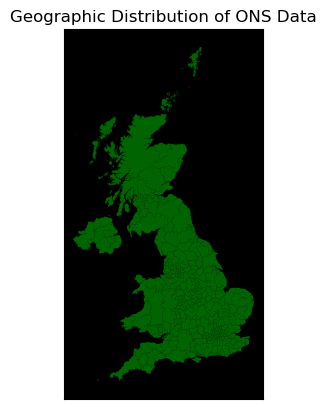

In [305]:
# plot data
# aesthetics
ax = mean_consumption.plot(color='darkgreen', markersize=1)

# background, remove axis labels & title
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Geographic Distribution of ONS Data')

# plot
plt.show()

## Final Merge and save as .gpkg

In [384]:
if not isinstance(mean_consumption, gpd.GeoDataFrame):
    mean_consumption = gpd.GeoDataFrame(mean_consumption)

# Merge the geographic DataFrame with the normal DataFrame
# 'LAD22CD' from 'mean_consumption' and 'Lower tier local authorities Code' from 'final_merged_df'
energyconsumption_df = mean_consumption.merge(final_merged_df, left_on='LAD22CD', right_on='Lower tier local authorities Code', how='left')

energyconsumption_df.head()

,LAD22CD,geometry,gas_median_cons_kwh,elec_median_cons_kwh,Lower tier local authorities Code,A caravan or other mobile or temporary structure,"Flat, maisonette or apartment",Whole house or bungalow: Detached,Whole house or bungalow: Semi-detached,Whole house or bungalow: Terraced,Does not apply,Does not have central heating,Has one type of central heating,Two or more types of central heating (including renewable energy),Two or more types of central heating (not including renewable energy),Average annual income (£)
0,E06000001,"POLYGON ((447213.900 537036.104, 447228.798 53...",9603.810817,2252.975000,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,0.0,342.0,36686.0,180.0,3722.0,33741.666667
1,E06000002,"POLYGON ((448489.897 522071.798, 448592.597 52...",11800.598665,2810.900000,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,0.0,752.0,53648.0,178.0,5684.0,35531.578947
2,E06000003,"POLYGON ((455525.931 528406.654, 455724.632 52...",9716.993667,2271.833333,E06000003,84.0,5496.0,12449.0,27942.0,15666.0,0.0,569.0,55316.0,310.0,5443.0,35515.789474
3,E06000004,"POLYGON ((444157.002 527956.304, 444165.898 52...",9882.238146,2398.133333,E06000004,79.0,7677.0,22209.0,35494.0,18298.0,0.0,705.0,75311.0,395.0,7346.0,38929.166667
4,E06000005,"POLYGON ((423496.602 524724.299, 423497.204 52...",10613.598673,2298.300000,E06000005,78.0,6424.0,9331.0,19148.0,13937.0,0.0,466.0,44320.0,227.0,3906.0,39380.000000


In [386]:
# final cleaning
# drop
energyconsumption_df.drop(columns=['Does not apply', 'Lower tier local authorities Code'], inplace=True)

# rename 'LAD22CD' to 'Local authority districts'
energyconsumption_df.rename(columns={'LAD22CD': 'Local authority districts'}, inplace=True)

# geometry as last column
geometry = energyconsumption_df.pop('geometry')
energyconsumption_df['geometry'] = geometry

# rename
column_rename_map = {
    'A caravan or other mobile or temporary structure': 'dwelling_type: mobile',
    'Flat, maisonette or apartment': 'dwelling_type: flat',
    'Whole house or bungalow: Detached': 'dwelling_type: detached house',
    'Whole house or bungalow: Semi-detached': 'dwelling_type: semi-detached',
    'Whole house or bungalow: Terraced': 'dwelling_type: terraced',
    'Does not have central heating': 'no central heating',
    'Has one type of central heating': '1 central heating',
    'Two or more types of central heating (including renewable energy)': '2+ central heating (renewable)',
    'Two or more types of central heating (not including renewable energy)': '2+ central heating (non-renewable)',
    'Average annual income (£)': 'mean annual income'
}
energyconsumption_df.rename(columns=column_rename_map, inplace=True)

# print
energyconsumption_df.head()

,Local authority districts,gas_median_cons_kwh,elec_median_cons_kwh,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income,geometry
0,E06000001,9603.810817,2252.975000,115.0,4725.0,8086.0,14537.0,13469.0,342.0,36686.0,180.0,3722.0,33741.666667,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,11800.598665,2810.900000,51.0,7569.0,10389.0,25485.0,16768.0,752.0,53648.0,178.0,5684.0,35531.578947,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,E06000003,9716.993667,2271.833333,84.0,5496.0,12449.0,27942.0,15666.0,569.0,55316.0,310.0,5443.0,35515.789474,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,E06000004,9882.238146,2398.133333,79.0,7677.0,22209.0,35494.0,18298.0,705.0,75311.0,395.0,7346.0,38929.166667,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,E06000005,10613.598673,2298.300000,78.0,6424.0,9331.0,19148.0,13937.0,466.0,44320.0,227.0,3906.0,39380.000000,"POLYGON ((423496.602 524724.299, 423497.204 52..."


In [388]:
# load in population data and normalise
ukpop = pd.read_excel('data/ukpopulation.xlsx', sheet_name='MYE2 - Persons')

ukpop.drop(columns=['Geography'], inplace=True)

# print
ukpop.head()

,Code,Name,population
0,E06000047,County Durham,528127
1,E06000005,Darlington,109469
2,E06000001,Hartlepool,93861
3,E06000002,Middlesbrough,148285
4,E06000057,Northumberland,324362


In [390]:
energyconsumption_df = energyconsumption_df.merge(ukpop, left_on='Local authority districts', right_on='Code', how='left')

energyconsumption_df.drop(columns=['Code'], inplace=True)

energyconsumption_df.rename(columns={'All ages': 'population'})

columns = list(energyconsumption_df.columns)

columns.remove('population')
columns.remove('Name')

# Insert 'population' and 'Name' at the desired new positions (index 1 and 2 respectively)
columns.insert(1, 'population')
columns.insert(2, 'Name')

# Reassign the columns to the DataFrame in the new order
energyconsumption_df = energyconsumption_df[columns]

# print
energyconsumption_df

,Local authority districts,population,Name,gas_median_cons_kwh,elec_median_cons_kwh,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income,geometry
0,E06000001,93861.0,Hartlepool,9603.810817,2252.975000,115.0,4725.0,8086.0,14537.0,13469.0,342.0,36686.0,180.0,3722.0,33741.666667,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,148285.0,Middlesbrough,11800.598665,2810.900000,51.0,7569.0,10389.0,25485.0,16768.0,752.0,53648.0,178.0,5684.0,35531.578947,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,E06000003,137175.0,Redcar and Cleveland,9716.993667,2271.833333,84.0,5496.0,12449.0,27942.0,15666.0,569.0,55316.0,310.0,5443.0,35515.789474,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,E06000004,199966.0,Stockton-on-Tees,9882.238146,2398.133333,79.0,7677.0,22209.0,35494.0,18298.0,705.0,75311.0,395.0,7346.0,38929.166667,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,E06000005,109469.0,Darlington,10613.598673,2298.300000,78.0,6424.0,9331.0,19148.0,13937.0,466.0,44320.0,227.0,3906.0,39380.000000,"POLYGON ((423496.602 524724.299, 423497.204 52..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,W06000020,92860.0,Torfaen,9085.194765,2330.350000,81.0,4748.0,8061.0,11220.0,16130.0,214.0,36001.0,181.0,3846.0,37000.000000,"POLYGON ((323898.201 211287.499, 324115.698 21..."
370,W06000021,93886.0,Monmouthshire,9529.052363,2642.420000,108.0,4211.0,18030.0,11747.0,6829.0,351.0,35997.0,422.0,4154.0,42800.000000,"MULTIPOLYGON (((345965.201 181030.700, 345944...."
371,W06000022,161506.0,Newport,9242.116840,2444.050000,148.0,10944.0,13654.0,20759.0,20549.0,554.0,59841.0,256.0,5403.0,40015.000000,"POLYGON ((342211.900 194845.495, 342221.803 19..."
372,W06000023,133891.0,Powys,8419.527015,2741.293750,539.0,4982.0,29176.0,15351.0,10134.0,1076.0,49627.0,909.0,8570.0,37563.157895,"POLYGON ((322392.901 334017.198, 322378.002 33..."


In [ ]:
# normalise columns
# columns to normalise
columns_to_normalise = [
    'dwelling_type: mobile', 'dwelling_type: flat', 'dwelling_type: detached house',
    'dwelling_type: semi-detached', 'dwelling_type: terraced', 'no central heating',
    '1 central heating', '2+ central heating (renewable)', '2+ central heating (non-renewable)'
]

# Create a new DataFrame for normalized data
normalised_energyconsumption_df = energyconsumption_df.copy()

# Normalize each specified column by the population column
for column in columns_to_normalise:
    normalised_energyconsumption_df[column] = normalised_energyconsumption_df[column] / normalised_energyconsumption_df['population']

# Ensure the geometry column is at the end if it exists
if 'geometry' in normalised_energyconsumption_df.columns:
    # Move the geometry column to the end
    geometry = normalised_energyconsumption_df.pop('geometry')
    normalised_energyconsumption_df['geometry'] = geometry

# Convert the DataFrame to a GeoDataFrame if it isn't already
if not isinstance(normalised_energyconsumption_df, gpd.GeoDataFrame):
    normalised_energyconsumption_df = gpd.GeoDataFrame(normalised_energyconsumption_df, geometry='geometry')

# Save the normalized DataFrame as a GeoPackage
normalised_energyconsumption_df.to_file("normalised_energyconsumption_df.gpkg", driver="GPKG")

In [400]:
normalised_energyconsumption_df.head()

,Local authority districts,population,Name,gas_median_cons_kwh,elec_median_cons_kwh,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income,geometry
0,E06000001,93861.0,Hartlepool,9603.810817,2252.975000,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654,33741.666667,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,148285.0,Middlesbrough,11800.598665,2810.900000,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332,35531.578947,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,E06000003,137175.0,Redcar and Cleveland,9716.993667,2271.833333,0.000612,0.040066,0.090753,0.203696,0.114204,0.004148,0.403251,0.002260,0.039679,35515.789474,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,E06000004,199966.0,Stockton-on-Tees,9882.238146,2398.133333,0.000395,0.038392,0.111064,0.177500,0.091506,0.003526,0.376619,0.001975,0.036736,38929.166667,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,E06000005,109469.0,Darlington,10613.598673,2298.300000,0.000713,0.058683,0.085239,0.174917,0.127315,0.004257,0.404863,0.002074,0.035681,39380.000000,"POLYGON ((423496.602 524724.299, 423497.204 52..."


In [394]:
if not isinstance(energyconsumption_df, gpd.GeoDataFrame):
    # Assuming 'geometry' is the column with geometry data
    energyconsumption_df = gpd.GeoDataFrame(energyconsumption_df, geometry='geometry')

# Save the GeoDataFrame as a GeoPackage
energyconsumption_df.to_file("energyconsumption_data.gpkg", driver="GPKG")